On travaille avec l'environnement CliffWalking de Gymnasium (voir la documentation https://gymnasium.farama.org/environments/toy_text/cliff_walking/), qui ressemble à un MDP vu dans l'un des TP précédents. On dispose de quatre actions (0, 1, 2, 3), ainsi que de 48 états (0, 1, ..., 47). L'état initial d'un épisode est toujours 36, et un épisode se termine lorsque l'état 47 est atteint. Le but du TP est d'implémenter un algorithme acteur-critique.

In [1]:
%pip install 'gymnasium[toy_text]'

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys

env = gym.make('CliffWalking-v0')

*Question 1*: Implémenter la fonction "softmax" qui à un vecteur $x\in \mathbb{R}^d$ associe le vecteur $\displaystyle \left(\frac{\exp\left( x_i \right) }{\sum_{j=1}^d\exp\left( x_j \right) }  \right)_{1\leqslant i\leqslant n}$.

In [3]:
def softmax(array):
    exp = np.exp(array)
    return exp/exp.sum()

On considère pour les politiques la classe paramétrique $\left\{
\pi_{\theta} \right\}_{\theta\in \mathbb{R}^{\mathcal{S}\times
\mathcal{A}}}$ où $\displaystyle \pi_{\theta}(\,\cdot\,|s)=\operatorname{softmax}\left( (\theta_{s,a})_{a\in \mathcal{A}} \right)$.

*Question 2*: Pour $\theta\in \mathbb{R}^{\mathcal{S}\times \mathcal{A}}$, $s\in
\mathcal{S}$ et $a\in \mathcal{A}$, calculer $\nabla_{\theta}\log\pi_{\theta}(a|s)$. Implémenter le calcul de ce gradient. On représentera un vecteur $\theta\in \mathcal{S}\times \mathcal{A}$
par un array NumPy de taille 48x4.

In [4]:
def grad_log_pi(s,a,theta):
    foo = np.zeros_like(theta)
    foo[s,a] = 1
    foo[s,:] -= softmax(theta[s])
    return foo

*Question 3*: Programmer une fonction qui pour $\theta\in \mathbb{R}^{\mathcal{S}\times \mathcal{A}}$ et $s\in
\mathcal{S}$ donnés, tire une action selon $\pi_{\theta}(\,\cdot\,|s)$.

In [5]:
def draw_action_pi(s, theta):
    # on pourra utiliser la fonction np.random.choice
    distr = softmax(theta[s])
    return np.random.choice(np.arange(4), p=distr)

Pour la *baseline*, on considère la classe paramétrique "tabulaire" $(v_w)_{w\in
\mathbb{R}^{\mathcal{S}}}$ où pour $w\in \mathbb{R}^\mathcal{S}$ et
$s\in \mathcal{S}$, $v_w(s)=w_s$.

*Question 4*: Compléter les fonctions suivantes.

In [6]:
def v(s,w):
    return w[s]

def grad_v(s,w):
    foo = np.zeros(48)
    foo[s] = 1
    return foo

*Question 5*: Implémenter l'algorithme acteur-critique du cours. Pour chaque exécution de l'algorithme, on tracera l'évolution de la longeur des épisodes. Observer les performances en essayant différentes valeurs pour les *pas* (alias *learning rate*). 

In [32]:
episode_lengths = []
n_episodes = 1000
theta = np.zeros((48,4))
w = np.zeros(48)
k = 0
gamma = 1
alpha = 3e-2
beta = 3e-2
for episode in range(n_episodes):
    sys.stdout.flush()

    s = env.reset()[0]

    terminated = False
    truncated = False

    episode_lengths.append(0)
    while not terminated:

        a = draw_action_pi(s, theta)
        s_, r, terminated, _, _ = env.step(a)

        advantage = r+gamma*v(s_,w)-v(s,w)

        w_gradient = advantage*grad_v(s,w)
        w += beta*w_gradient

        theta_gradient = gamma ** episode_lengths[-1] * advantage * grad_log_pi(s,a,theta)
        theta += alpha*theta_gradient

        s = s_

        episode_lengths[-1] += 1
        k += 1

    print("\rStep {} @ Episode {}/{} (length {})".format(k, episode + 1, n_episodes, episode_lengths[-1]), end="")

Step 26001 @ Episode 1000/1000 (length 15)

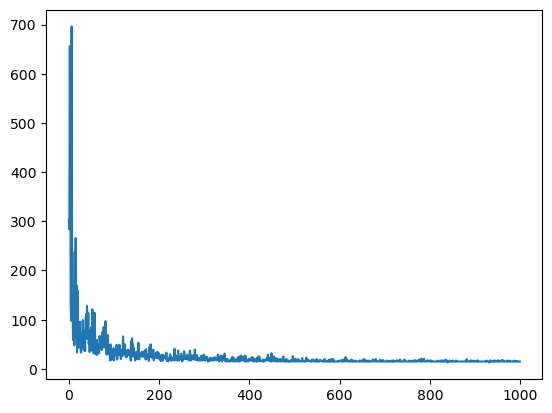

In [33]:
plt.plot(episode_lengths)

Dans sa version la plus basique, l'algorithme acteur-critique utilise la descent de gradient stochastique (SGD) pour la mise à jour des paramètres $\theta$ et $w$, SGD s'écrivant de façon générale $x_{t+1}=x_t-\alpha \hat{g}_t$ où $\hat{g}_t$ est un estimateur stochastique du gradient évalué en $x_t$ de la fonction à minimiser. Il existe des variantes, comme par exemple l'algorithme Adam, très utilisé en Deep Learning, qui s'écrit composante par composante : 
$\displaystyle x_{t+1,i}=x_{t,i}-\frac{\eta}{\varepsilon+\sqrt{\sum_{s=1}^t\beta_2^{t-s}\hat{g}_{s,i}^2}}\sum_{s=1}^t\beta_1^{t-s}\hat{g}_{s,i},\quad 1\leqslant i\leqslant n.$

où on peut prendre par exemple $\varepsilon=10^{-7}$, $\beta_1=0.9$ et $\beta_2=0.999$.

*Question 6*: Modifier l'algorithme en remplaçant SGD par Adam. Comparer les performances.

In [34]:
episode_lengths = []
n_episodes = 1000
theta = np.zeros((48,4))
w = np.zeros(48)
k = 0
gamma = 1
adam_lr_theta = 1e-1
adam_lr_w = 1e-1
m1_w = np.zeros_like(w)
m2_w = np.zeros_like(w)
m1_theta = np.zeros_like(theta)
m2_theta = np.zeros_like(theta)
for episode in range(n_episodes):
    sys.stdout.flush()

    s = env.reset()[0]

    terminated = False
    truncated = False

    episode_lengths.append(0)
    while not terminated:

        a = draw_action_pi(s, theta)
        s_, r, terminated, _, _ = env.step(a)

        advantage = r+gamma*v(s_,w)-v(s,w)

        w_gradient = advantage*grad_v(s,w)
        m1_w = .9* m1_w + w_gradient
        m2_w = .999*m2_w + w_gradient**2
        w += adam_lr_w*np.multiply(np.reciprocal(1e-7+np.sqrt(m2_w)),m1_w)

        theta_gradient = gamma ** episode_lengths[-1] * advantage * grad_log_pi(s,a,theta)
        m1_theta = .9* m1_theta + theta_gradient
        m2_theta = .999*m2_theta + theta_gradient**2
        theta += adam_lr_theta*np.multiply(np.reciprocal(1e-7+np.sqrt(m2_theta)),m1_theta)

        s = s_

        episode_lengths[-1] += 1
        k += 1

    print("\rStep {} @ Episode {}/{} (length {})".format(k, episode + 1, n_episodes, episode_lengths[-1]), end="")

Step 17404 @ Episode 1000/1000 (length 13)

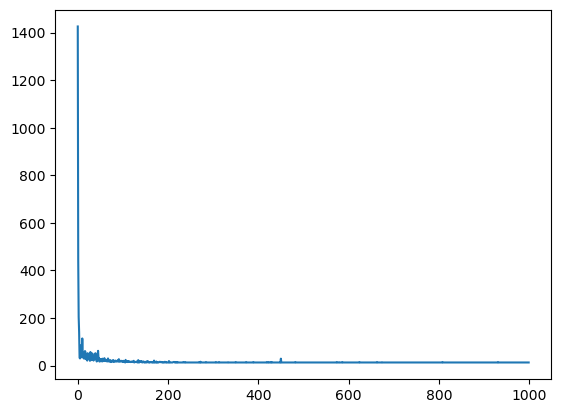

In [29]:
plt.plot(episode_lengths)

*Question 7*: Implémenter REINFORCE (avec et sans baseline). Comparer les performances.